In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient
from glob import glob
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

2023-01-31 09:17:20.500087: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-31 09:17:20.500200: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
GCS_DS_PATH = KaggleDatasets().get_gcs_path('website-defacement')

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
N_JOBS = cpu_count()

IMG_SIZE = 224
EPOCHS = 50

print('N_JOBS:', N_JOBS)
print('Batch size:', BATCH_SIZE)
print('GCS_DS_PATH:', GCS_DS_PATH)

Running on TPU: grpc://10.0.0.2:8470


2023-01-31 09:17:26.960902: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-31 09:17:26.963775: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-01-31 09:17:26.963824: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-31 09:17:26.963857: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (028ac0ee51bd): /proc/driver/nvidia/version does not exist
2023-01-31 09:17:26.966474: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

N_JOBS: 4
Batch size: 64
GCS_DS_PATH: gs://kds-0216339375dff4a7db6d61f7800f92202e600e6c4067e2d30681bc6c


In [3]:
dataset_path = '../input/website-defacement/'
img_paths = glob(dataset_path + 'image/*/*')
txt_paths = glob(dataset_path + 'text/*/*')
img_names = [path.split('/')[-1][:-4] for path in img_paths]
txt_names = [path.split('/')[-1][:-4] for path in txt_paths]
names = list(set(img_names).intersection(txt_names))

# Text-based Detection

In [4]:
def prepare_data(name):
    if glob(dataset_path + f'text/defaced/{name}.txt'):
        path = dataset_path + f'text/defaced/{name}.txt'
        label = 1
    else:
        path = dataset_path + f'text/benign/{name}.txt'
        label = 0
    with open(path, 'r') as f:
        text = f.read()
    return (text, label)

output = Parallel(n_jobs=N_JOBS)(delayed(prepare_data)(name) for name in tqdm(names))
X, y = zip(*output)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, 
                                                      random_state=42)

print(len(X_train), len(X_valid), len(X_test))

  0%|          | 0/96234 [00:00<?, ?it/s]

57740 19247 19247


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(X_train)

MAXLEN = 128

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAXLEN)
y_train = np.array(y_train)

X_valid = tokenizer.texts_to_sequences(X_valid)
X_valid = pad_sequences(X_valid, maxlen=MAXLEN)
y_valid = np.array(y_valid)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=MAXLEN)
y_test = np.array(y_test)

In [6]:
train_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_train, y_train))
    .shuffle(100000)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices(X_test)
    .batch(BATCH_SIZE)
)

valid_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_valid, y_valid))
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

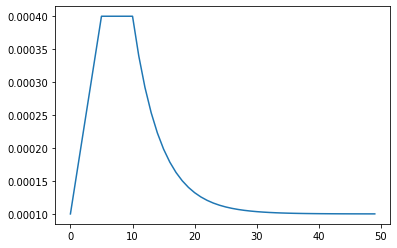

In [7]:
def lrfn(epoch=EPOCHS,
         lr_start=1e-4,
         lr_max=5e-5 * 8, 
         lr_min=1e-4,
         lr_rampup_epochs=5,
         lr_sustain_epochs=5,
         lr_exp_decay=0.8):
    if epoch < lr_rampup_epochs:
        lr = (lr_max-lr_start)/lr_rampup_epochs*epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max-lr_min)*lr_exp_decay**(epoch-lr_rampup_epochs-lr_sustain_epochs) + lr_min
    return lr

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

y = [lrfn(x) for x in range(EPOCHS)]
plt.plot(y)

In [8]:
vocab_size = len(tokenizer.word_index) + 1

with strategy.scope():
    model = Sequential()
    model.add(L.Embedding(input_dim=vocab_size,
                          output_dim=64, 
                          input_length=X_train.shape[1]))
    model.add(L.Conv1D(64, 5))
    model.add(L.GlobalMaxPooling1D())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 64)           175912832 
_________________________________________________________________
conv1d (Conv1D)              (None, 124, 64)           20544     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 175,933,506
Trainable params: 175,933,506
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('text-cnn.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[lrs, mc], 
                 validation_data=valid_dataset, verbose=2)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 175912832 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 39s - loss: 0.1553 - accuracy: 0.9351 - val_loss: 0.0906 - val_accuracy: 0.9672
Epoch 2/50
902/902 - 31s - loss: 0.0201 - accuracy: 0.9939 - val_loss: 0.0916 - val_accuracy: 0.9703
Epoch 3/50
902/902 - 32s - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0978 - val_accuracy: 0.9701
Epoch 4/50
902/902 - 31s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1015 - val_accuracy: 0.9696
Epoch 5/50
902/902 - 31s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.1041 - val_accuracy: 0.9698
Epoch 6/50
902/902 - 32s - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.1067 - val_accuracy: 0.9695
Epoch 7/50
902/902 - 31s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.1086 - val_accuracy: 0.9696
Epoch 8/50
902/902 - 31s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.1100 - val_accuracy: 0.9697
Epoch 9/50
902/902 - 31s - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.1111 - val_accuracy: 0.9696
Epoch 10/50
902/902 - 31s - loss: 0.0010 - accuracy: 0.9996 - val_loss: 0.1117 - val_accuracy: 0.9696


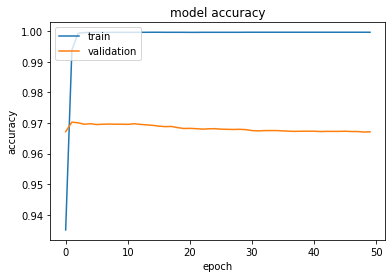

In [10]:
plot_hist(hist)

In [11]:
with strategy.scope():
    model.load_weights('text-cnn.h5')

y_prob_txt = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_txt, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_txt[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_txt[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 6s 10ms/step
              precision    recall  f1-score   support

           0     0.9620    0.9850    0.9733     11431
           1     0.9772    0.9431    0.9598      7816

    accuracy                         0.9679     19247
   macro avg     0.9696    0.9640    0.9666     19247
weighted avg     0.9682    0.9679    0.9678     19247

[[11259   172]
 [  445  7371]]
      TPR       FPR       FNR   ROC AUC
   0.9431    0.0150    0.0569    0.9940


In [12]:
y_prob_txt_cnn = y_prob_txt

### Text-GRU


In [13]:
vocab_size = len(tokenizer.word_index) + 1

with strategy.scope():
    model = Sequential()
    model.add(L.Embedding(input_dim=vocab_size,
                          output_dim=64, 
                          input_length=X_train.shape[1]))
    model.add(L.Bidirectional(L.GRU(64, return_sequences=True)))
    model.add(L.GlobalMaxPooling1D())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 64)           175912832 
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 128)          49920     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 175,963,010
Trainable params: 175,963,010
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('text-gru.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[lrs, mc], 
                 validation_data=valid_dataset, verbose=2)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 175912832 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 46s - loss: 0.1409 - accuracy: 0.9406 - val_loss: 0.0828 - val_accuracy: 0.9704
Epoch 2/50
902/902 - 36s - loss: 0.0150 - accuracy: 0.9951 - val_loss: 0.1089 - val_accuracy: 0.9686
Epoch 3/50
902/902 - 35s - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.1221 - val_accuracy: 0.9682
Epoch 4/50
902/902 - 35s - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1320 - val_accuracy: 0.9683
Epoch 5/50
902/902 - 35s - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.1340 - val_accuracy: 0.9679
Epoch 6/50
902/902 - 35s - loss: 0.0010 - accuracy: 0.9996 - val_loss: 0.1459 - val_accuracy: 0.9679
Epoch 7/50
902/902 - 35s - loss: 9.8988e-04 - accuracy: 0.9996 - val_loss: 0.1573 - val_accuracy: 0.9675
Epoch 8/50
902/902 - 36s - loss: 9.7984e-04 - accuracy: 0.9996 - val_loss: 0.1578 - val_accuracy: 0.9673
Epoch 9/50
902/902 - 35s - loss: 9.5738e-04 - accuracy: 0.9996 - val_loss: 0.1668 - val_accuracy: 0.9670
Epoch 10/50
902/902 - 35s - loss: 9.4008e-04 - accuracy: 0.9997 - val_loss: 0.1774 - val_a

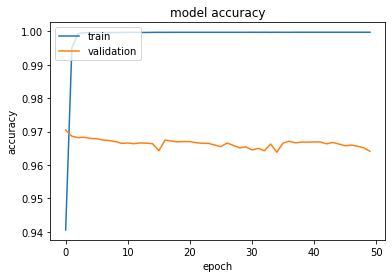

In [15]:
plot_hist(hist)

In [16]:
with strategy.scope():
    model.load_weights('text-gru.h5')

y_prob_txt = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_txt, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_txt[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_txt[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 5s 14ms/step
              precision    recall  f1-score   support

           0     0.9659    0.9860    0.9758     11431
           1     0.9789    0.9491    0.9638      7816

    accuracy                         0.9710     19247
   macro avg     0.9724    0.9675    0.9698     19247
weighted avg     0.9712    0.9710    0.9709     19247

[[11271   160]
 [  398  7418]]
      TPR       FPR       FNR   ROC AUC
   0.9491    0.0140    0.0509    0.9947


In [17]:
y_prob_txt_gru = y_prob_txt

### Bidirectional LSTM


In [18]:
vocab_size = len(tokenizer.word_index) + 1

with strategy.scope():
    model = Sequential()
    model.add(L.Embedding(input_dim=vocab_size,
                          output_dim=64, 
                          input_length=X_train.shape[1]))
    model.add(L.Bidirectional(L.LSTM(64, return_sequences=True)))
    model.add(L.GlobalMaxPooling1D())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 64)           175912832 
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 128)          66048     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 175,979,138
Trainable params: 175,979,138
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('text-lstm.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[lrs, mc], 
                 validation_data=valid_dataset, verbose=2)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 175912832 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 47s - loss: 0.1505 - accuracy: 0.9378 - val_loss: 0.0837 - val_accuracy: 0.9698
Epoch 2/50
902/902 - 35s - loss: 0.0197 - accuracy: 0.9939 - val_loss: 0.1111 - val_accuracy: 0.9681
Epoch 3/50
902/902 - 35s - loss: 0.0046 - accuracy: 0.9990 - val_loss: 0.1276 - val_accuracy: 0.9699
Epoch 4/50
902/902 - 35s - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.1259 - val_accuracy: 0.9684
Epoch 5/50
902/902 - 35s - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.1262 - val_accuracy: 0.9688
Epoch 6/50
902/902 - 35s - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.1267 - val_accuracy: 0.9687
Epoch 7/50
902/902 - 35s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.1356 - val_accuracy: 0.9682
Epoch 8/50
902/902 - 35s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.1383 - val_accuracy: 0.9685
Epoch 9/50
902/902 - 35s - loss: 0.0010 - accuracy: 0.9996 - val_loss: 0.1492 - val_accuracy: 0.9678
Epoch 10/50
902/902 - 35s - loss: 9.6900e-04 - accuracy: 0.9996 - val_loss: 0.1520 - val_accuracy: 0.9

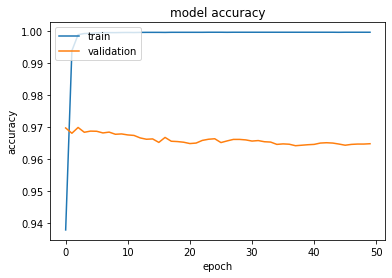

In [20]:
plot_hist(hist)

In [21]:
with strategy.scope():
    model.load_weights('text-lstm.h5')

y_prob_txt = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_txt, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_txt[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_txt[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 9s 13ms/step
              precision    recall  f1-score   support

           0     0.9650    0.9855    0.9752     11431
           1     0.9781    0.9478    0.9627      7816

    accuracy                         0.9702     19247
   macro avg     0.9716    0.9666    0.9689     19247
weighted avg     0.9703    0.9702    0.9701     19247

[[11265   166]
 [  408  7408]]
      TPR       FPR       FNR   ROC AUC
   0.9478    0.0145    0.0522    0.9946


In [22]:
y_prob_txt_lstm = y_prob_txt

# Fusion with Image-based Detection

In [23]:
def prepare_data(name):
    if glob(dataset_path + f'image/defaced/{name}.png'):
        return (f'{GCS_DS_PATH}/image/defaced/{name}.png', 1)
    else:
        return (f'{GCS_DS_PATH}/image/benign/{name}.png', 0)

output = Parallel(n_jobs=N_JOBS)(delayed(prepare_data)(name) for name in tqdm(names))
X, y = zip(*output)

X_train, X_test, y_train, y_test_ = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, 
                                                      random_state=42)

print(len(X_train), len(X_valid), len(X_test))
print((y_test == y_test_).all())

  0%|          | 0/96234 [00:00<?, ?it/s]

57740 19247 19247
True


In [24]:
def decode_image(filename, label=None):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_png(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    if label is None:
        return image
    else:
        return image, label

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices(X_test)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

## ViTB32


In [25]:
!pip install --quiet vit-keras

from vit_keras import vit

In [26]:
!pip install -q efficientnet
from efficientnet.tfkeras import EfficientNetB0

with strategy.scope():
    net = vit.vit_b32(
        image_size = (IMG_SIZE, IMG_SIZE),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False
    )
    model = Sequential()
    model.add(net)
    model.add(L.BatchNormalization())
    model.add(L.Dense(128, activation='softmax'))
    model.add(L.BatchNormalization())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.load_weights('../input/deface-vitb32/weights.h5')

353255424/353253686 [==============================] - 11s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


In [27]:
y_prob_img = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_img, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_img[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_img[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 672s 2s/step
              precision    recall  f1-score   support

           0     0.8941    0.9309    0.9121     11431
           1     0.8925    0.8388    0.8648      7816

    accuracy                         0.8935     19247
   macro avg     0.8933    0.8848    0.8885     19247
weighted avg     0.8934    0.8935    0.8929     19247

[[10641   790]
 [ 1260  6556]]
      TPR       FPR       FNR   ROC AUC
   0.8388    0.0691    0.1612    0.9563


### Fusion

**Text_CNN**

In [28]:
y_prob = (y_prob_img + y_prob_txt_cnn) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9693    0.9880    0.9786     11431
           1     0.9820    0.9542    0.9679      7816

    accuracy                         0.9743     19247
   macro avg     0.9756    0.9711    0.9732     19247
weighted avg     0.9744    0.9743    0.9742     19247

[[11294   137]
 [  358  7458]]
      TPR       FPR       FNR   ROC AUC
   0.9542    0.0120    0.0458    0.9946


**Text_GRU**

In [29]:
y_prob = (y_prob_img + y_prob_txt_gru) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9727    0.9853    0.9790     11431
           1     0.9781    0.9596    0.9687      7816

    accuracy                         0.9749     19247
   macro avg     0.9754    0.9724    0.9739     19247
weighted avg     0.9749    0.9749    0.9748     19247

[[11263   168]
 [  316  7500]]
      TPR       FPR       FNR   ROC AUC
   0.9596    0.0147    0.0404    0.9949


**Text_LSTM**

In [30]:
y_prob = (y_prob_img + y_prob_txt_lstm) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9714    0.9860    0.9786     11431
           1     0.9791    0.9575    0.9682      7816

    accuracy                         0.9744     19247
   macro avg     0.9752    0.9718    0.9734     19247
weighted avg     0.9745    0.9744    0.9744     19247

[[11271   160]
 [  332  7484]]
      TPR       FPR       FNR   ROC AUC
   0.9575    0.0140    0.0425    0.9946


## VGG19

In [31]:
from tensorflow.keras.applications import VGG19

with strategy.scope():
    net = VGG19(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3))

    model = Sequential()
    model.add(net)
    model.add(L.BatchNormalization())
    model.add(L.Dense(128, activation='softmax'))
    model.add(L.BatchNormalization())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.load_weights('../input/deface-vgg19/weights.h5')

80142336/80134624 [==============================] - 0s 0us/step


In [32]:
y_prob_img = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_img, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_img[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_img[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 507s 2s/step
              precision    recall  f1-score   support

           0     0.7887    0.8359    0.8116     11431
           1     0.7370    0.6725    0.7032      7816

    accuracy                         0.7695     19247
   macro avg     0.7628    0.7542    0.7574     19247
weighted avg     0.7677    0.7695    0.7676     19247

[[9555 1876]
 [2560 5256]]
      TPR       FPR       FNR   ROC AUC
   0.6725    0.1641    0.3275    0.8111


### Fusion

**Text_CNN**

In [33]:
y_prob = (y_prob_img + y_prob_txt_cnn) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9617    0.9911    0.9762     11431
           1     0.9863    0.9423    0.9638      7816

    accuracy                         0.9713     19247
   macro avg     0.9740    0.9667    0.9700     19247
weighted avg     0.9717    0.9713    0.9712     19247

[[11329   102]
 [  451  7365]]
      TPR       FPR       FNR   ROC AUC
   0.9423    0.0089    0.0577    0.9888


**Text_GRU**

In [34]:
y_prob = (y_prob_img + y_prob_txt_gru) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9669    0.9899    0.9783     11431
           1     0.9846    0.9505    0.9673      7816

    accuracy                         0.9739     19247
   macro avg     0.9758    0.9702    0.9728     19247
weighted avg     0.9741    0.9739    0.9738     19247

[[11315   116]
 [  387  7429]]
      TPR       FPR       FNR   ROC AUC
   0.9505    0.0101    0.0495    0.9896


**Text_LSTM**

In [35]:
y_prob = (y_prob_img + y_prob_txt_lstm) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

              precision    recall  f1-score   support

           0     0.9653    0.9890    0.9770     11431
           1     0.9833    0.9481    0.9653      7816

    accuracy                         0.9724     19247
   macro avg     0.9743    0.9685    0.9712     19247
weighted avg     0.9726    0.9724    0.9723     19247

[[11305   126]
 [  406  7410]]
      TPR       FPR       FNR   ROC AUC
   0.9481    0.0110    0.0519    0.9880


## DenseNet169

In [36]:
from tensorflow.keras.applications import DenseNet169

with strategy.scope():
    net = DenseNet169(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3))

    model = Sequential()
    model.add(net)
    model.add(L.BatchNormalization())
    model.add(L.Dense(128, activation='softmax'))
    model.add(L.BatchNormalization())
    model.add(L.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.load_weights('../input/deface-densenet169/weights.h5')

51879936/51877672 [==============================] - 0s 0us/step


In [37]:
y_prob_img = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob_img, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_img[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob_img[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 511s 2s/step
              precision    recall  f1-score   support

           0     0.8670    0.9640    0.9129     11431
           1     0.9371    0.7836    0.8535      7816

    accuracy                         0.8908     19247
   macro avg     0.9020    0.8738    0.8832     19247
weighted avg     0.8955    0.8908    0.8888     19247

[[11020   411]
 [ 1691  6125]]
      TPR       FPR       FNR   ROC AUC
   0.7836    0.0360    0.2164    0.9615


### Fusion

**Text_CNN**

In [38]:
y_prob = (y_prob_img + y_prob_txt_cnn) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)

              precision    recall  f1-score   support

           0     0.9618    0.9936    0.9775     11431
           1     0.9902    0.9423    0.9656      7816

    accuracy                         0.9728     19247
   macro avg     0.9760    0.9680    0.9716     19247
weighted avg     0.9733    0.9728    0.9727     19247

[[11358    73]
 [  451  7365]]


**Text_GRU**

In [39]:
y_prob = (y_prob_img + y_prob_txt_gru) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)

              precision    recall  f1-score   support

           0     0.9652    0.9919    0.9783     11431
           1     0.9876    0.9477    0.9672      7816

    accuracy                         0.9739     19247
   macro avg     0.9764    0.9698    0.9728     19247
weighted avg     0.9743    0.9739    0.9738     19247

[[11338    93]
 [  409  7407]]


**Text_LSTM**

In [40]:
y_prob = (y_prob_img + y_prob_txt_lstm) / 2
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)

              precision    recall  f1-score   support

           0     0.9649    0.9924    0.9784     11431
           1     0.9884    0.9472    0.9673      7816

    accuracy                         0.9740     19247
   macro avg     0.9766    0.9698    0.9729     19247
weighted avg     0.9744    0.9740    0.9739     19247

[[11344    87]
 [  413  7403]]


## ViTl32

In [41]:
# def decode_image(filename, label=None):
#     bits = tf.io.read_file(filename)
#     image = tf.image.decode_png(bits, channels=1)
#     image = tf.cast(image, tf.float32) / 255.0
#     image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
#     image = tf.reshape(image, (IMG_SIZE, IMG_SIZE))
    
#     if label is None:
#         return image
#     else:
#         return image, label

# test_dataset = (
#     tf.data.TFRecordDataset
#     .from_tensor_slices(X_test)
#     .map(decode_image, num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE)
# )

In [42]:
# with strategy.scope():
#     model = Sequential()
#     model.add(L.Bidirectional(L.LSTM(units=64, return_sequences=True, dropout=0.2, 
#                                      recurrent_dropout=0.2), input_shape=(IMG_SIZE, IMG_SIZE)))
#     model.add(L.Bidirectional(L.LSTM(units=64, return_sequences=True, dropout=0.2, 
#                                      recurrent_dropout=0.2)))
#     model.add(L.Bidirectional(L.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2)))
#     model.add(L.Dense(16, activation='softmax'))
#     model.add(L.BatchNormalization())
#     model.add(L.Dense(2, activation='softmax'))
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     model.load_weights('../input/deface-vitl32/weights.h5')

In [43]:
# y_prob_img = model.predict(test_dataset, verbose=1)
# y_pred = np.argmax(y_prob_img, axis=1)

# clf_report = metrics.classification_report(y_test, y_pred, digits=4)
# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# TN, FP, FN, TP = cnf_matrix.ravel()
# TPR = TP / (TP + FN)
# FPR = FP / (FP + TN)
# FNR = FN / (FN + TP)
# fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_img[:, 1])
# auc = metrics.roc_auc_score(y_test, y_prob_img[:, 1])
# other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
#                               'FPR': '%.4f' % FPR, 
#                               'FNR': '%.4f' % FNR, 
#                               'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
# print(clf_report)
# print(cnf_matrix)
# print(other_metrics)

### Fusion

In [44]:
# y_prob = (y_prob_img + y_prob_txt) / 2
# y_pred = np.argmax(y_prob, axis=1)

# clf_report = metrics.classification_report(y_test, y_pred, digits=4)
# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# TN, FP, FN, TP = cnf_matrix.ravel()
# TPR = TP / (TP + FN)
# FPR = FP / (FP + TN)
# FNR = FN / (FN + TP)
# fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
# auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
# other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
#                               'FPR': '%.4f' % FPR, 
#                               'FNR': '%.4f' % FNR, 
#                               'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
# print(clf_report)
# print(cnf_matrix)